In [34]:
import pyaudio #handling recording function
import wave #handling .wav file
import numpy as np
import matplotlib.pyplot as plt
import time
from cmath import exp, pi

%matplotlib inline

class Recorder:
    def __init__(self):
        # recording time (unit:s)
        self.record_time = 5
        # file name
        self.output_wavfile = "record.wav"
        # index number of microscope  
        self.idevice = 1
        # format of audio                    
        self.format = pyaudio.paInt16
        # monaural
        self.nchannels = 1
        # sample rate that is usually 44.1kHz as sampling frequency                  
        self.sampling_rate = 44100
        # number of extracted data at a time, that is called Chunk          
        self.chunk = 2**10
        # get device information                 
        self.audio = pyaudio.PyAudio()
    
    def __exit__(self):
        self.close()
        
    def set_config(self):
        #foundimental information
        #format of audio
        self.format = pyaudio.paInt16
        #monaural
        self.nchannels = 1
        #sample rate that is usually 44.1kHz as sampling frequency      
        self.sampling_rate = 44100
        #number of extracted data at a time, that is called Chunk
        self.chunk = 2**10
        
    def show_deviceinfo(self):
        for i in range(self.audio.get_device_count()):
            print(self.audio.get_device_info_by_index(i))

    def record(self, wfile_list):
        for w in wfile_list:
            stream = self.audio.open(format = self.format,
            channels = self.nchannels,
            rate = self.sampling_rate,
            input = True,
            input_device_index = self.idevice, # Mouse_マイク will be used for input signal
            frames_per_buffer = self.chunk)

            print ("start recording...")
            frames = []
            for i in range(0, int(self.sampling_rate / self.chunk * self.record_time)):
                data = stream.read(self.chunk) #chunkごとにdataを書き出す
                frames.append(data)
            print ("finished recording\n")
            self.prepare_file(frames, w)
            
    def prepare_file(self, frames, wfile="record.wav", mode='wb'):
        if wfile != "record.wav":
            self.output_wavfile = wfile
        wavefile = wave.open(wfile, mode)
        wavefile.setnchannels(self.nchannels)
        wavefile.setsampwidth(self.audio.get_sample_size(self.format))
        wavefile.setframerate(self.sampling_rate)
        wavefile.writeframes(b"".join(frames))
        return wavefile
        
    def close(self):
        stream.close()
        self.audio.terminate()
        self.output_wavfile.close()
#end of class Record

#def callback(in_data, frame_count, time_info, status):
#    data = wf.readframes(frame_count)
#    return (data, pyaudio.paContinue)

In [35]:
#Recording test...
n = 50
wavlist = []
for i in range(n):
    wavlist.append("record"+str(i)+".wav")

#print(wavlist)
record = Recorder()
#record.set_config()
record.record(wavlist[:3])
#record.show_deviceinfo()

#waveFile.writeframes(b"".join(frames))

#x = np.frombuffer(data, dtype="int16") / float(2**15)#32768.0
#plt.figure(figsize=(15,3))
#plt.plot(x)
#plt.show()

start recording...
finished recording

start recording...
finished recording

start recording...
finished recording



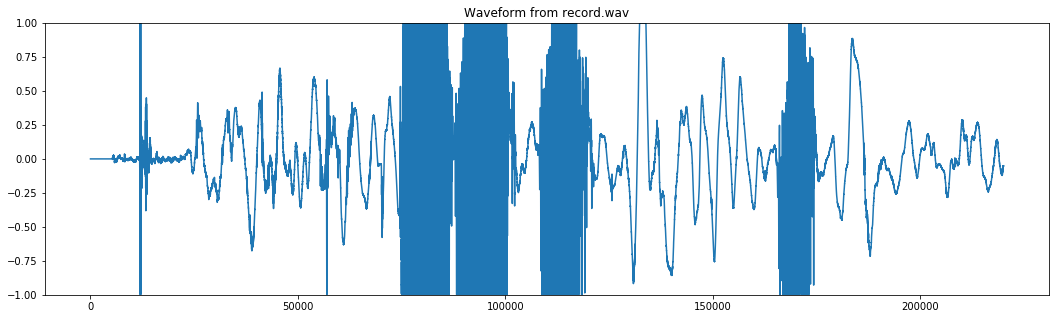

In [36]:
spf = wave.open("record0.wav", "rb")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1) #wave_fileから全データを読みこむ
signal = np.frombuffer(signal, dtype="int16") / float(2**15) #ndarrayに変換

plt.figure(figsize=(18,5))
plt.title("Waveform from record.wav")
plt.ylim(-1, 1)
plt.plot(signal)
plt.show()

In [37]:
from scipy.fftpack import fft, rfft

def _fft(x):
    N = len(x)
    if N <= 1: return x
    even = _fft(x[0::2])
    odd  = _fft(x[1::2])
    T = [exp(-2j*pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

dataSz = signal.shape
print(signal)
print(dataSz) #220160
fft_list = np.resize(signal, 2**int(np.log2(dataSz))) #1024*131072
print(fft_list.shape)

f = _fft(fft_list)
f2 = fft(fft_list)/(len(fft_list)/2)

#print(f)
#print("fft_list2 = ", f2)

[ 0.00000000e+00  0.00000000e+00 -3.05175781e-05 ... -5.29785156e-02
 -5.24291992e-02 -5.23681641e-02]
(220160,)
(131072,)


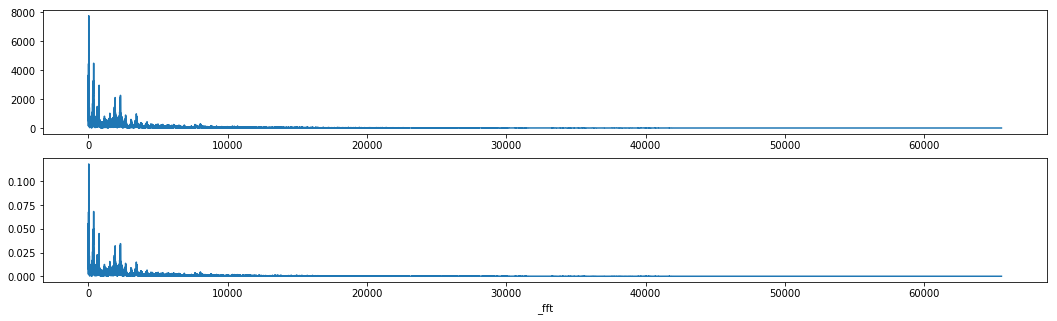

In [38]:
plt.figure(figsize=(18,5))
plt.title("_fft process")
plt.subplot(211)
plt.plot(np.abs(f)[0:len(fft_list)//2], label="_fft")
plt.subplot(212)
audio_list = np.abs(f2)[:len(fft_list)//2]
plt.plot(audio_list, label="fft")
plt.xlabel("_fft")
plt.show()

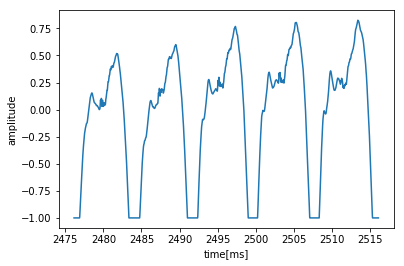

In [39]:
import wave
import numpy as np
from pylab import *

def wav_read(filename):
    wf = wave.open(filename, "rb")
    fs = wf.getframerate()
    x = wf.readframes(wf.getnframes())
    x = np.frombuffer(x, dtype="int16")/32768.0 #(-1,1)にnormalize
    wf.close()
    return x, float(fs)

if __name__ == "__main__":
    #音声をロード
    wav, fs = wav_read("record0.wav")
    t = np.arange(0.0, len(wav)/fs, 1/fs)
    
    #音声波形の中心部を切り出す
    center = len(wav)//2
    cuttime = 0.04
    wavdata = wav[center-int(cuttime/2*fs):center+int(cuttime/2*fs)]
    time = t[center-int(cuttime/2*fs):center+int(cuttime/2*fs)]
    
    #波形をプロット
    plot(time*1000, wavdata)
    xlabel("time[ms]")
    ylabel("amplitude")
    savefig("waveform.png")
    show()

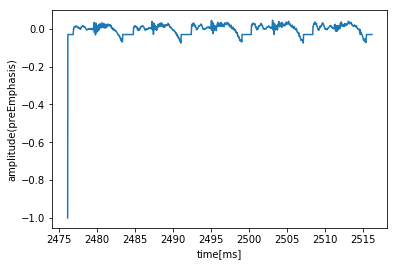

In [40]:
import scipy.signal

#プリエンファシスフィルタ
def preEmphasis(signal, p):
    #signal = voice_signal, p = coefficient
    #make FIR filter such that coefficients are (1.0, p)
    return scipy.signal.lfilter([1.0, -p], 1, signal)

# multiply preEmphasis filter
p = 0.97
signal = preEmphasis(wavdata, p)

plot(time*1000, signal)
xlabel("time[ms]")
ylabel("amplitude(preEmphasis)")
savefig("wave_preEmphasis.png")
show()

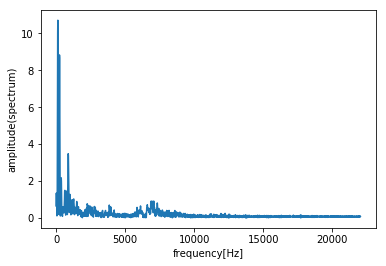

In [41]:
# hamming windowをかける
hammingWindow = np.hamming(len(signal))
signal = signal * hammingWindow

# get spectrum
nfft = 2**12
spec = np.abs(np.fft.fft(signal, nfft))[:nfft//2]
fscale = np.fft.fftfreq(nfft, d = 1.0/fs)[:nfft//2]

plot(fscale, spec)
xlabel("frequency[Hz]")
ylabel("amplitude(spectrum)")
savefig("wave_spectrum.png")
show()

In [42]:
def hz2mel(f):
    return 1127.01048 * np.log(f/700.0 + 1.0)

def mel2hz(m):
    return 700*(np.exp(m/1127.01048) - 1.0)

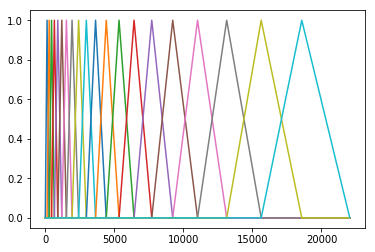

In [43]:
def melFilterBank(fs, nfft, nchannels):
    #ナイキスト周波数
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = nfft // 2
    df = fs / nfft
    dmel = melmax / (nchannels + 1)
    melcenters = np.arange(1, nchannels + 1) * dmel
    fcenter = mel2hz(melcenters)
    indexcenter = np.round(fcenter / df)
    indexstart = np.hstack((0, indexcenter[0:nchannels - 1]))
    # 各フィルタの終了位置のインデックス
    indexstop = np.hstack((indexcenter[1:nchannels], [nmax]))
    
    filterbank = np.zeros((nchannels, nmax))
    
    for c in np.arange(0, nchannels):
        # 三角フィルタの左の直線の傾きから点を求める
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        for i in np.arange(indexstart[c], indexcenter[c]):
            filterbank[c, int(i)] = (i - indexstart[c]) * increment
        # 三角フィルタの右の直線の傾きから点を求める
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        for i in np.arange(indexcenter[c], indexstop[c]):
            filterbank[c, int(i)] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenter

numChannels = 20
df = fs / nfft
filterbank, fcenters = melFilterBank(fs, nfft, numChannels)

for c in np.arange(0, numChannels):
    plot(np.arange(0, nfft / 2) * df, filterbank[c])

savefig("melfilterbank.png")
show()

In [44]:
# 振幅スペクトルに対してフィルタバンクの各フィルタをかけ、
# 振幅の和の対数をとる
mspec = []
for c in np.arange(0, numChannels):
    mspec.append(np.log10(sum(spec * filterbank[c])))
mspec = np.array(mspec)

In [45]:
from scipy.fftpack import realtransforms

def get_mfcc(mspec, nceps):
    #離散コサイン変換 DCT
    ceps = realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    #低次の成分からnceps個の係数を返す
    return ceps[:nceps]

mfcc = get_mfcc(mspec, 12)
print(type(mfcc))
mfcc

<class 'numpy.ndarray'>


array([ 5.88055718e+00,  2.08887930e-02,  3.81340521e-01,  3.27773872e-01,
       -5.52735031e-02,  1.06142597e-01,  2.95385295e-01,  3.12423137e-03,
        3.86985179e-01,  2.94478529e-01, -6.25083924e-02,  9.66938794e-03])

In [46]:
# 1.mfccで特徴量をget
# 2.ndarrayのmfccをpandasとか何かを使ってcsv fileにでも書き出す
# 3.csvからDataFrameの形にして、sklearnとかで扱えるようにする
import pandas as pd

a = np.arange(12).reshape((4,3))
#print(a)

In [47]:
columns = [str(i) for i in range(12)]
# print(columns)
mfcc_df = pd.DataFrame(mfcc).T
# pandas列追加
mfcc_df["target"] = [0]
print(mfcc_df)

          0         1         2         3         4         5         6  \
0  5.880557  0.020889  0.381341  0.327774 -0.055274  0.106143  0.295385   

          7         8         9        10        11  target  
0  0.003124  0.386985  0.294479 -0.062508  0.009669       0  
